# Improvement (Stability, Tie-break and Cumulative PFI)

In [150]:
# Create eigenvalues table correctly
eigen_df <- data.frame(
  PC = paste0("V", 1:length(transformed_jfpca$fpca_res$latent)),
  Variance = transformed_jfpca$fpca_res$latent
)

head(eigen_df)

,PC,Variance
,<chr>,<dbl>
1,V1,12134713161
2,V2,4540604877
3,V3,1454111428
4,V4,642578226
5,V5,276717557
6,V6,141421121


In [151]:
print(head(pfi_df))
str(pfi_df)

   K Fold Trees PC         PFI
1 10    1    50 V1 0.014998261
2 10    1    50 V2 0.012649782
3 10    1    50 V3 0.012998858
4 10    1    50 V4 0.009488547
5 10    1    50 V5 0.006288117
6 10    1    50 V6 0.005965618
'data.frame':	2200 obs. of  5 variables:
 $ K    : num  10 10 10 10 10 10 10 10 10 10 ...
 $ Fold : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Trees: num  50 50 50 50 50 50 50 50 50 50 ...
 $ PC   : chr  "V1" "V2" "V3" "V4" ...
 $ PFI  : num  0.015 0.01265 0.013 0.00949 0.00629 ...


In [152]:
# STABILITY + MEAN PFI 
tau <- 0.6  # PC must be stable in ≥60% of folds

stability_df <- pfi_df %>%                   # ⚠ use pfi_df because it contains PFI for each fold
  group_by(K, Trees, PC) %>%
  summarise(
    Stability = mean(PFI > 0),              # frequency of PFI > 0
    Mean_PFI  = mean(PFI),                  # average PFI
    .groups = "drop"
  ) %>%
  left_join(eigen_df, by = "PC")            # join with variance for tie-break

# Tie-break using variance
filtered_df <- stability_df %>%
  filter(Stability >= tau) %>%              # select PCs that are stable
  arrange(desc(Mean_PFI), desc(Variance))   # sort by high PFI, then high variance

print(filtered_df)


# A tibble: 440 × 6
       K Trees PC    Stability Mean_PFI     Variance
   <dbl> <dbl> <chr>     <dbl>    <dbl>        <dbl>
 1    10   500 V1            1   0.0147 12134713161.
 2    10    50 V1            1   0.0144 12134713161.
 3    10   300 V1            1   0.0135 12134713161.
 4    10   300 V3            1   0.0135  1454111428.
 5    10   100 V1            1   0.0134 12134713161.
 6    10   100 V3            1   0.0132  1454111428.
 7    10   500 V3            1   0.0121  1454111428.
 8    10    50 V3            1   0.0114  1454111428.
 9    10    50 V2            1   0.0109  4540604877.
10    20    50 V1            1   0.0106 12134713161.
# ℹ 430 more rows


In [153]:
filtered_df <- filtered_df %>%
  group_by(K, Trees) %>%
  mutate(
    Norm_PFI = Mean_PFI / sum(Mean_PFI),
    Cum_PFI  = cumsum(Norm_PFI)
  )

# 4. Chọn PC đủ để giải thích 90% “importance”
selected_final_pcs <- filtered_df %>%
  filter(Cum_PFI <= 0.90)

print(selected_final_pcs)

# A tibble: 281 × 8
# Groups:   K, Trees [16]
       K Trees PC    Stability Mean_PFI     Variance Norm_PFI Cum_PFI
   <dbl> <dbl> <chr>     <dbl>    <dbl>        <dbl>    <dbl>   <dbl>
 1    10   500 V1            1   0.0147 12134713161.    0.238   0.238
 2    10    50 V1            1   0.0144 12134713161.    0.234   0.234
 3    10   300 V1            1   0.0135 12134713161.    0.223   0.223
 4    10   300 V3            1   0.0135  1454111428.    0.223   0.446
 5    10   100 V1            1   0.0134 12134713161.    0.218   0.218
 6    10   100 V3            1   0.0132  1454111428.    0.215   0.433
 7    10   500 V3            1   0.0121  1454111428.    0.197   0.435
 8    10    50 V3            1   0.0114  1454111428.    0.185   0.418
 9    10    50 V2            1   0.0109  4540604877.    0.177   0.595
10    20    50 V1            1   0.0106 12134713161.    0.174   0.174
# ℹ 271 more rows


In [154]:
pander(
  selected_final_pcs,
  style = "grid",   
  split.table = Inf 
)



+----+-------+-----+-----------+-----------+-----------+----------+---------+
| K  | Trees | PC  | Stability | Mean_PFI  | Variance  | Norm_PFI | Cum_PFI |
+====+=======+=====+===========+===========+===========+==========+=========+
| 10 |  500  | V1  |     1     |  0.01466  | 1.213e+10 |  0.238   |  0.238  |
+----+-------+-----+-----------+-----------+-----------+----------+---------+
| 10 |  50   | V1  |     1     |  0.01444  | 1.213e+10 |  0.2336  | 0.2336  |
+----+-------+-----+-----------+-----------+-----------+----------+---------+
| 10 |  300  | V1  |     1     |  0.0135   | 1.213e+10 |  0.223   |  0.223  |
+----+-------+-----+-----------+-----------+-----------+----------+---------+
| 10 |  300  | V3  |     1     |  0.01347  | 1.454e+09 |  0.2225  | 0.4456  |
+----+-------+-----+-----------+-----------+-----------+----------+---------+
| 10 |  100  | V1  |     1     |  0.01339  | 1.213e+10 |  0.2181  | 0.2181  |
+----+-------+-----+-----------+-----------+-----------+------

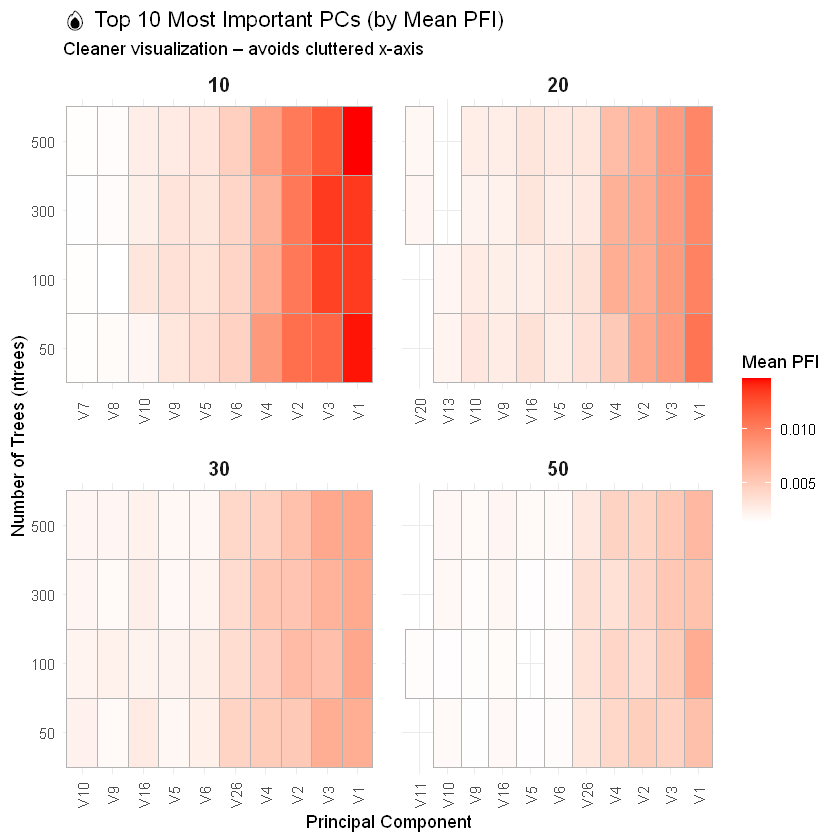

In [155]:
# Select only the Top 10 most important PCs by Mean_PFI
top10_pfi <- pfi_summary %>%
  group_by(K, Trees) %>%
  arrange(desc(Mean_PFI)) %>%
  slice_head(n = 10) %>%
  ungroup()

# Plot a clean heatmap (showing only the Top 10 important PCs)
ggplot(top10_pfi, aes(x = reorder(PC, Mean_PFI), y = factor(Trees), fill = Mean_PFI)) +
  geom_tile(color = "grey70") +
  scale_fill_gradient(low = "white", high = "red") +
  labs(
    title = "🔥 Top 10 Most Important PCs (by Mean PFI)",
    subtitle = "Cleaner visualization – avoids cluttered x-axis",
    x = "Principal Component",
    y = "Number of Trees (ntrees)",
    fill = "Mean PFI"
  ) +
  facet_wrap(~ K, scales = "free_x") +  # separate subplot for each K
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 90, vjust = 0.5, size = 9),
    strip.text = element_text(size = 12, face = "bold"),
    panel.spacing = unit(1.1, "lines")
  )
